# Modeling elections

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 3 columns, representing Trump (Republican), Biden (Democrat), and Other in that order. In the example below, Trump got 340 votes in the first survey, Biden got 258, and Other got 40.
```
  >>> survey_results['Indiana']
  array([[340, 258,  40],
         [240, 155,  10],
         [235, 155,  70],
         [308, 266,  84],
         [222, 161, 110]])
```
Data from [Wikipedia: Statewide opinion polling for the 2020 United States presidential election](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_2020_United_States_presidential_election)


In [2]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


In [8]:
states

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado']

In [9]:
survey_results

{'Alabama': array([[611, 397,   0],
        [799, 528,   0],
        [793, 403,   0],
        [288, 264,   0],
        [353, 219,   0],
        [997, 554,   0],
        [312, 232,   0],
        [409, 227,   0],
        [319, 234,   0]]),
 'Alaska': array([[348, 320,   0],
        [298, 253,   0],
        [283, 277,   0],
        [269, 198,   0],
        [227, 177,   0],
        [442, 389,   0],
        [519, 486,   0],
        [325, 318,   0],
        [ 84,  74,   0]]),
 'Arizona': array([[ 522,  478,   22],
        [ 313,  356,   14],
        [ 291,  304,    0],
        [ 270,  288,    0],
        [ 236,  264,   16],
        [ 180,  184,    0],
        [ 133,  151,    0],
        [ 269,  321,   20],
        [ 230,  250,    5],
        [3337, 3621,    0],
        [ 360,  392,    0],
        [ 235,  235,    0],
        [ 364,  396,    8],
        [ 383,  409,   18],
        [ 221,  216,    0],
        [ 113,  128,    0],
        [ 284,  278,    0],
        [ 168,  212,    0],
        [ 

## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 5 states, so you will have 5 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [53]:
stan_code = '''

data {
    int<lower=0> num_survey;    // number of surveys
    int<lower=0> num_candidate;   // number of candidates
    int<lower=0> survey_results[num_survey, num_candidate];     // results for the candidate
}

parameters {
    vector<lower=0>[num_candidate] alpha; // alpha of the dirichlet dist
    simplex[num_candidate] p[num_survey];  // the probability vector for each survey
}

model {
    alpha ~ cauchy(0, 1);
    for (i in 1:num_survey) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eb460c5e4aa50933afb38fe70423f4a NOW.


### Alabama

In [71]:
stan_data = {
    'num_survey': survey_results['Colorado'].shape[0],
    'num_candidate': 3,
    'survey_results': survey_results['Colorado']}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
# Make a new array with same dimensions as alpha
p_predicted1 = np.empty(samples['alpha'].shape)
# Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted1[i] = sts.dirichlet(samples['alpha'][i]).rvs()


In [61]:
repub=[]
demo=[]
other=[]
repub_prob =[]
demo_prob=[]
other_prob=[]
for i in range(len(samples)):
    repub.append(samples['alpha'][i][0])
    repub_prob.append(p_predicted1[i][0])
    demo.append(samples['alpha'][i][1])
    demo_prob.append(p_predicted1[i][1])
    other.append(samples['alpha'][i][2])
    other_prob.append(p_predicted1[i][2])
print("Republican number of votes is", np.percentile(repub, [2.5, 97.5]))
print("Democrat number of votes is", np.percentile(demo, [2.5, 97.5]))
print("Other number of votes is", np.percentile(other, [2.5, 97.5]))


Republican number of votes is [46.90306099 62.01645036]
Democrat number of votes is [60.02612122 82.21576917]
Other number of votes is [0.07357466 0.13244697]


In [62]:
print("Republican winning prob is", np.percentile(repub_prob, [2.5, 97.5]))
print("Democrat winning prob is", np.percentile(demo_prob, [2.5, 97.5]))
print("Other winning prob is", np.percentile(other_prob, [2.5, 97.5]))


Republican winning prob is [0.42439101 0.45646207]
Democrat winning prob is [0.54353791 0.57539449]
Other winning prob is [8.08356372e-10 2.14507859e-04]


### Alaska

In [63]:
stan_data = {
    'num_survey': survey_results['Alaska'].shape[0],
    'num_candidate': 3,
    'survey_results': survey_results['Alaska']}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
# Make a new array with same dimensions as alpha
p_predicted1 = np.empty(samples['alpha'].shape)
# Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted1[i] = sts.dirichlet(samples['alpha'][i]).rvs()
repub=[]
demo=[]
other=[]
repub_prob =[]
demo_prob=[]
other_prob=[]
for i in range(len(samples)):
    repub.append(samples['alpha'][i][0])
    repub_prob.append(p_predicted1[i][0])
    demo.append(samples['alpha'][i][1])
    demo_prob.append(p_predicted1[i][1])
    other.append(samples['alpha'][i][2])
    other_prob.append(p_predicted1[i][2])
print("Republican number of votes is", np.percentile(repub, [2.5, 97.5]))
print("Democrat number of votes is", np.percentile(demo, [2.5, 97.5]))
print("Other number of votes is", np.percentile(other, [2.5, 97.5]))
print("Republican winning prob is", np.percentile(repub_prob, [2.5, 97.5]))
print("Democrat winning prob is", np.percentile(demo_prob, [2.5, 97.5]))
print("Other winning prob is", np.percentile(other_prob, [2.5, 97.5]))


Republican number of votes is [ 49.3653437  289.89737979]
Democrat number of votes is [ 40.44323676 260.01254356]
Other number of votes is [0.18063784 0.30756434]
Republican winning prob is [0.53857326 0.55344692]
Democrat winning prob is [0.44654892 0.46122014]
Other winning prob is [4.16661886e-06 2.06596800e-04]


### Arizona

In [64]:
stan_data = {
    'num_survey': survey_results['Arizona'].shape[0],
    'num_candidate': 3,
    'survey_results': survey_results['Arizona']}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
# Make a new array with same dimensions as alpha
p_predicted1 = np.empty(samples['alpha'].shape)
# Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted1[i] = sts.dirichlet(samples['alpha'][i]).rvs()
repub=[]
demo=[]
other=[]
repub_prob =[]
demo_prob=[]
other_prob=[]
for i in range(len(samples)):
    repub.append(samples['alpha'][i][0])
    repub_prob.append(p_predicted1[i][0])
    demo.append(samples['alpha'][i][1])
    demo_prob.append(p_predicted1[i][1])
    other.append(samples['alpha'][i][2])
    other_prob.append(p_predicted1[i][2])
print("Republican number of votes is", np.percentile(repub, [2.5, 97.5]))
print("Democrat number of votes is", np.percentile(demo, [2.5, 97.5]))
print("Other number of votes is", np.percentile(other, [2.5, 97.5]))
print("Republican winning prob is", np.percentile(repub_prob, [2.5, 97.5]))
print("Democrat winning prob is", np.percentile(demo_prob, [2.5, 97.5]))
print("Other winning prob is", np.percentile(other_prob, [2.5, 97.5]))

Republican number of votes is [41.04709413 50.77984032]
Democrat number of votes is [43.94443769 56.90881446]
Other number of votes is [0.14218628 0.20024611]
Republican winning prob is [0.4535809  0.51530821]
Democrat winning prob is [0.48469126 0.54641868]
Other winning prob is [1.51161145e-07 5.35453010e-06]


### Arkansas

In [65]:
stan_data = {
    'num_survey': survey_results['Arkansas'].shape[0],
    'num_candidate': 3,
    'survey_results': survey_results['Arkansas']}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
# Make a new array with same dimensions as alpha
p_predicted1 = np.empty(samples['alpha'].shape)
# Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted1[i] = sts.dirichlet(samples['alpha'][i]).rvs()
repub=[]
demo=[]
other=[]
repub_prob =[]
demo_prob=[]
other_prob=[]
for i in range(len(samples)):
    repub.append(samples['alpha'][i][0])
    repub_prob.append(p_predicted1[i][0])
    demo.append(samples['alpha'][i][1])
    demo_prob.append(p_predicted1[i][1])
    other.append(samples['alpha'][i][2])
    other_prob.append(p_predicted1[i][2])
print("Republican number of votes is", np.percentile(repub, [2.5, 97.5]))
print("Democrat number of votes is", np.percentile(demo, [2.5, 97.5]))
print("Other number of votes is", np.percentile(other, [2.5, 97.5]))
print("Republican winning prob is", np.percentile(repub_prob, [2.5, 97.5]))
print("Democrat winning prob is", np.percentile(demo_prob, [2.5, 97.5]))
print("Other winning prob is", np.percentile(other_prob, [2.5, 97.5]))

Republican number of votes is [ 1.54230714 11.14025471]
Democrat number of votes is [1.11411806 5.0578239 ]
Other number of votes is [0.0767191  0.18632873]
Republican winning prob is [0.37855559 0.93938656]
Democrat winning prob is [0.06020069 0.6210189 ]
Other winning prob is [6.72010151e-07 7.84294208e-03]


### Colorado

In [66]:
stan_data = {
    'num_survey': survey_results['Colorado'].shape[0],
    'num_candidate': 3,
    'survey_results': survey_results['Colorado']}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
# Make a new array with same dimensions as alpha
p_predicted1 = np.empty(samples['alpha'].shape)
# Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted1[i] = sts.dirichlet(samples['alpha'][i]).rvs()
repub=[]
demo=[]
other=[]
repub_prob =[]
demo_prob=[]
other_prob=[]
for i in range(len(samples)):
    repub.append(samples['alpha'][i][0])
    repub_prob.append(p_predicted1[i][0])
    demo.append(samples['alpha'][i][1])
    demo_prob.append(p_predicted1[i][1])
    other.append(samples['alpha'][i][2])
    other_prob.append(p_predicted1[i][2])
print("Republican number of votes is", np.percentile(repub, [2.5, 97.5]))
print("Democrat number of votes is", np.percentile(demo, [2.5, 97.5]))
print("Other number of votes is", np.percentile(other, [2.5, 97.5]))
print("Republican winning prob is", np.percentile(repub_prob, [2.5, 97.5]))
print("Democrat winning prob is", np.percentile(demo_prob, [2.5, 97.5]))
print("Other winning prob is", np.percentile(other_prob, [2.5, 97.5]))

Republican number of votes is [43.88453029 78.12249554]
Democrat number of votes is [ 57.19108453 105.8206508 ]
Other number of votes is [0.07747764 0.18508046]
Republican winning prob is [0.33447859 0.43389485]
Democrat winning prob is [0.56610437 0.66552138]
Other winning prob is [1.89023047e-09 7.76017910e-07]


### Overall winner

In [80]:
overall_results = {}
#get results from all states
for i in states:
    stan_data = {
        'num_survey': survey_results[i].shape[0],
        'num_candidate': 3,
        'survey_results': survey_results[i]}
    overall_results[i] = stan_model.sampling(data=stan_data)
samples = {i: overall_results[i].extract() for i in states}
votes = np.zeros((4000, 4))
winner = np.zeros(4000)
for i in range(4000):
    for j in states:
        alpha = samples[j]['alpha'][i]
        p_predict_overall = sts.dirichlet.rvs(alpha)
        win = p_predict_overall.argmax() #max p = winner
        votes[i, win] += electoral_votes[j]
    winner[i] = votes[i].argmax()


In [89]:
winner

array([1., 1., 1., ..., 1., 0., 0.])

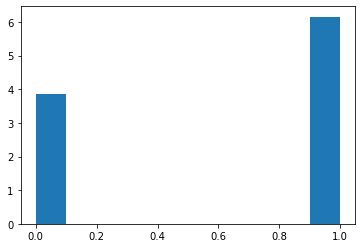

In [86]:
plt.hist(winner, density=True)
plt.show() #0 pertains to republican, 1 pertains to democrat, 2 pertains to Other - we see there's no "other here"

In [90]:
#since there is no "Other"
print("Probability of republican winning is", 1-sum(winner)/len(winner))
print("Probability of democratic winning is", sum(winner)/len(winner))

Probability of republican winning is 0.38449999999999995
Probability of democratic winning is 0.6155
